# LIBS spectra simulation

In [9]:
import numpy as np
from scipy.special import voigt_profile as voigt
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
def peak_maker(
    element,
    inc=1,
    w_lo=190,
    w_hi=950,
    sigma=1,
    gamma=1,
    shift=True,
    shift_type='sys',
    shift_mean=0,
    height=True,
    height_type='random',
    height_mean=0,
    height_mag=0.001,
    artifact=True,
    art_type='square',
    art_mag=0.01,
    noise=True,
    noise_type='Gaussian',
    snr=10,
    plot=True,
    path="/Google Drive/My Drive/Projects/python/LIBS/slim_db"):
    
    """ create a peak profile based on slim database entries for a given 'element'
        the slim_db is a condensed version of the NIST database that only includes neutral (I) ions
    """

    data = np.load(path + str(element) + ".npy")
    
    gA_pos = np.transpose(np.argwhere(data[:, 5]))[0].astype(int)[1:]

    rel_int = data[gA_pos, 5].astype(float)
    rel_int = rel_int / np.sum(rel_int, axis=0)
        
    peak_loc = data[gA_pos, 3].astype(float)
    maxpeak = np.argmax(rel_int)
    maxwv = peak_loc[maxpeak]
    peak_pos = np.flip(np.argsort(rel_int))
        
#     plot histogram of element intensities
#     plt.hist(rel_int, 100)
#     plt.xlabel('normalized intensity [au]')
#     plt.ylabel('quantity')
#     plt.show
    
    peak_count = len(rel_int)
    wave = np.arange(w_lo, w_hi, inc)
    
    # jitter peak positions and intensities
    if shift:
        if shift_type=='sys': # apply systematic peak shift
            peak_loc = peak_loc + shift_mean
        if shift=='random': # apply random peak shift
            mag = shift_mean * np.random.rand(peak_count)
            peak_loc = peak_loc + mag
    
    if height:
        if height_type=='random':
            h_mult = np.random.rand(peak_count) + 0.5
            rel_int = h_mult * rel_int
            rel_int = rel_int / np.sum(rel_int, axis=0)
        if height_type=='lin':
            h_mult = height_mag*peak_loc + height_mean
            rel_int = h_mult * rel_int
    
    # create peaks with defined Voigt profiles from peak location and intensities derived from database
    peaks = np.array([a * voigt(wave - x, sigma, gamma) for a, x in zip(rel_int, peak_loc)])
    spec = np.sum(peaks, axis=0)
    
    if plot:
        plt.plot(wave, spec)
        plt.xlabel('wavelength [nm]')
        plt.ylabel('intensity')
        plt.xlim([190, 950])
        plt.show
    
    return wave, spec

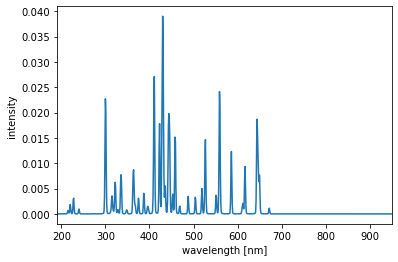

In [27]:
test_spec = peak_maker('Ca', gamma=.1, sigma=1, snr=10, plot=True, path="slim_db/");
#np.save('Li_test', test_spec)

In [21]:
class spectrum_maker():
    """ fracs is an array of element fractions for elements in periodic table order """
    
    def __init__(self):
        self.elements = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Uut', 'Fl', 'Uup', 'Lv', 'Uus', 'Uuo']
        self.amt = np.zeros(len(self.elements))
        self.el_dict = dict(zip(self.elements, self.amt))
    
    def stoichiometry(self, fracs):
        if len(fracs) < len(self.elements):
            fracs = np.pad(fracs, len(self.elements))
                        
        elif len(fracs) > len(self.elements):
            raise ValueError("More values given than elements on the periodic table. spectrum_maker needs 118 values or fewer")
            
        fracs /= np.sum(fracs) # normalize element fractions to 1
        self.el_dict = dict(zip(self.elements, fracs))
        
        return self.el_dict
        
    def make_spectra(self, 
        fracs,
        inc=1,
        w_lo=190, # lower limit of spectrum
        w_hi=950, # upper limit of spectrum
        artifact=True, # flag to include spectral artifacts ('constant', 'square', or 'Gaussian')
        art_type=['square', 'Gaussian'], # types of artifacts to be included - must be a list for now
        art_mag=0.01, # relative magnitude of artifact to spectrum intensity
        sigma=True, # noise 
        mu=True,
        a=True,
        noise=True, # noise flag
        noise_type='Gaussian', # noise type
        snr=10):
        
        specs = np.argwhere(fracs)
        self.el_dict = dict(zip(self.elements, fracs))
        spec_array_len = np.count_nonzero(specs) + 1
        
        spec_array = np.zeros((spec_array_len, int(w_hi-w_lo))) # preallocate full spectral data array
        
        # --- loop over elements for which spectra will be generated    
        for i, j in zip(specs, self.el_dict):
            _, spec_array[i] = self.el_dict[j] * np.array(peak_maker(j, gamma=.1, sigma=.1, plot=False, path="/Users/whitta/Projects/python/LIBS/slim_db/"))
        
        wave = np.arange(w_lo, w_hi, inc)
        
        # --- sum elemental spectra
        spec = np.sum(spec_array, axis=0)
        spec /= np.sum(spec)
        
        # --- add artifacts
        art = np.zeros(len(spec))
        if artifact:
            if any([i=='const' for i in art_type]):
                art += art_mag*np.max(spec)
                
            if any([i=='square' for i in art_type]):
                lim = np.sort(np.random.choice(wave, 2))
                idx = (wave>lim[0])*(wave<lim[1])
                sq_loc = np.where(idx)[0]
                art_scale = art_mag*np.max(spec)
                art[sq_loc] += art_scale
                
            if any([i=='Gaussian' for i in art_type]):
                if sigma:
                    sigma = (w_hi-w_lo)*0.5
                if mu:
                    mu = np.random.randint(w_lo,w_hi)
                bg = np.random.rand() * 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (wave - mu)**2 / (2 * sigma**2))
                art += bg
                
        spec += art
        spec_array = np.append(spec_array, np.expand_dims(art, 0), axis=0)
        
        # --- add noise
        noi = np.zeros(len(spec))
        if noise:
            if noise_type=='Gaussian':
                noi += np.random.normal(0, 1/snr**2, len(noi))
        
        spec += noi
        spec_array = np.append(spec_array, np.expand_dims(noi, 0), axis=0)
                
        return wave, spec, spec_array

In [22]:
def syn_data_1():
    """ syn_datmakes synthetic distribution of elements of the first n elements on the periodic table.
        For testing only
    """
    
    fracs = np.pad(np.random.rand(20), (0,98))
    fracs /= np.sum(fracs)
    
    return fracs